## Anuran Audio Classification and Segmentation using Transformers

In [ ]:
# Part 1: Training and Validation
# 0) Imports

import os, glob, gc, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torchaudio
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
from transformers import ASTForAudioClassification, AutoFeatureExtractor
from sklearn.model_selection import train_test_split
import zipfile
import subprocess
from pathlib import Path
import umap


In [ ]:

# 1) Mount Google Drive

from google.colab import drive
drive.mount("/content/drive")



Mounted at /content/drive


In [ ]:

# 2) Local Drive Shift


# CONFIG
DRIVE_ZIP = "/content/drive/MyDrive/anuraset.zip"
LOCAL_ZIP = "/content/anuraset.zip"
LOCAL_EXTRACT_ROOT = "/content"
LOCAL_AUDIO_DIR = "/content/anuraset"   # folder that will appear after unzip
# -----------------------------------------------------------

print("Setting up AnuraSet")

# 1. Check ZIP on Drive
if not os.path.exists(DRIVE_ZIP):
    raise FileNotFoundError(f"ZIP not found on Drive: {DRIVE_ZIP}")
else:
    print(f"Found Drive ZIP: {DRIVE_ZIP}")

# 2. Copy ZIP locally (only if missing or outdated)
need_copy = False
reason = ""

if not os.path.exists(LOCAL_ZIP):
    need_copy = True
    reason = "no local zip"
else:
    drive_mtime = os.path.getmtime(DRIVE_ZIP)
    local_mtime = os.path.getmtime(LOCAL_ZIP)
    if drive_mtime > local_mtime:
        need_copy = True
        reason = "Drive zip is newer"

if need_copy:
    print(f"Copying ZIP to local ({reason})...")
    os.system(f'cp "{DRIVE_ZIP}" "{LOCAL_ZIP}"')
else:
    print("Local ZIP already up-to-date.")

# 3. Extract locally only if missing
if not os.path.isdir(LOCAL_AUDIO_DIR) or len(list(Path(LOCAL_AUDIO_DIR).rglob("*"))) == 0:
    print("Extracting ZIP into /content ...")
    with zipfile.ZipFile(LOCAL_ZIP, "r") as zf:
        zf.extractall(LOCAL_EXTRACT_ROOT)
    print("Extracted folder:", LOCAL_AUDIO_DIR)
else:
    print("Extracted folder already exists.")

# 4. Sanity check WAV count
wav_count = sum(1 for _ in Path(LOCAL_AUDIO_DIR).rglob("*.wav"))
print(f"🎧 WAV files found locally: {wav_count}")


Setting up AnuraSet
Found Drive ZIP: /content/drive/MyDrive/anuraset.zip
Copying ZIP to local (no local zip)...
Extracting ZIP into /content ...
Extracted folder: /content/anuraset
🎧 WAV files found locally: 93378


In [ ]:

# 3) Batch size and Epochs

META_PATH   = "/content/drive/MyDrive/Anura Audio Set/anuraset/metadata.csv"

TARGET_SR   = 16000 # audio sampling rate (16 kHz)
BATCH_SIZE  = 16
LR          = 1e-4
N_CLASSES   = 42

TARGET_LEN  = 48000   # dataset is exactly 3s windows
MIN_SAMPLES = 400

EPOCHS      = 30      # early stopping will stop earlier
PATIENCE    = 4
THRESHOLD   = 0.5
SEED        = 42      # seed for reproducibility

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print("device:", device)



device: cuda


In [ ]:

# 4) Load metadata + label columns

META = pd.read_csv(META_PATH)

meta_cols = [
    "sample_name","fname","min_t","max_t",
    "site","date","species_number","subset"
]
label_cols = [c for c in META.columns if c not in meta_cols]
assert len(label_cols) == N_CLASSES, f"Expected {N_CLASSES} labels, got {len(label_cols)}"

META[label_cols] = (
    META[label_cols]
      .apply(pd.to_numeric, errors="coerce")
      .fillna(0)
      .astype("float32")
)

print("rows:", len(META), "label cols:", len(label_cols))




rows: 93378 label cols: 42


In [ ]:

# 5) Build wav_map from LOCAL FILES ONLY

paths = glob.glob(os.path.join(LOCAL_AUDIO_DIR, "**", "*.wav"), recursive=True)
wav_map = {os.path.basename(p): p for p in paths}

print("local wav_map size:", len(wav_map))



local wav_map size: 93378


In [ ]:

# 6) Audio helpers

def resolve_filename(row):
    sample = row["sample_name"]
    constructed = f"{row['fname']}_{int(row['min_t'])}_{int(row['max_t'])}.wav"
    return sample, constructed

def load_wav_safe(path, target_sr=TARGET_SR):
    wav, sr = sf.read(path)
    if wav.ndim == 2:
        wav = wav.mean(axis=1)
    wav = torch.tensor(wav, dtype=torch.float32)

    if sr != target_sr:
        wav = torchaudio.functional.resample(
            wav.unsqueeze(0), sr, target_sr
        ).squeeze(0)

    return wav



In [ ]:

# 7) Feature extractor + AST model (init ONCE)

FEATURE_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
feature_extractor = AutoFeatureExtractor.from_pretrained(FEATURE_ID)
ast_model = ASTForAudioClassification.from_pretrained(FEATURE_ID)

hidden = ast_model.config.hidden_size
ast_model.classifier = nn.Linear(hidden, N_CLASSES)

ast_model.config.num_labels = N_CLASSES
ast_model.config.problem_type = "multi_label_classification"

model = ast_model.to(device)
print("model num_labels:", model.config.num_labels)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model num_labels: 42


In [ ]:

# 8) Dataset

class AnuraSetAST(Dataset):
    def __init__(self, meta_df, wav_map, label_cols):
        self.meta = meta_df.reset_index(drop=True)
        self.wav_map = wav_map
        self.label_cols = label_cols

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        s, c = resolve_filename(row)

        if s in self.wav_map:
            fname = s
        elif c in self.wav_map:
            fname = c
        else:
            raise FileNotFoundError(f"Missing audio for {s} / {c}")

        wav = load_wav_safe(self.wav_map[fname])
        label = torch.from_numpy(row[self.label_cols].to_numpy(dtype="float32"))
        return wav, label



In [ ]:

# 9) Faster collate (pads/truncs -> feature extractor)

def collate_ast_safe(batch):
    wavs, labels = zip(*batch)

    fixed_wavs = []
    fixed_labels = []

    for w, y in zip(wavs, labels):
        w = w.float().flatten()
        if w.numel() < MIN_SAMPLES:
            continue

        if w.numel() < TARGET_LEN:
            w = torch.nn.functional.pad(w, (0, TARGET_LEN - w.numel()))
        else:
            w = w[:TARGET_LEN]

        fixed_wavs.append(w)
        fixed_labels.append(y)

    if len(fixed_wavs) == 0:
        fixed_wavs = [torch.zeros(TARGET_LEN)]
        fixed_labels = [torch.zeros(N_CLASSES)]

    wav_batch = torch.stack(fixed_wavs)        # (B,T)
    labels_batch = torch.stack(fixed_labels)   # (B,C)

    inputs = feature_extractor(
        wav_batch.numpy(),
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True
    )

    return inputs, labels_batch




In [ ]:

# 10) Train/Val split + DataLoaders

train_df, val_df = train_test_split(
    META, test_size=0.15, random_state=SEED, shuffle=True
)

train_ds = AnuraSetAST(train_df, wav_map, label_cols)
val_ds   = AnuraSetAST(val_df,   wav_map, label_cols)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_ast_safe
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    persistent_workers=True,
    collate_fn=collate_ast_safe
)

print("⚡ train batches:", len(train_loader), "val batches:", len(val_loader))

gc.collect()
torch.cuda.empty_cache()


⚡ train batches: 4961 val batches: 876


In [ ]:

# 11) Multi-label metrics

def multilabel_metrics(logits, labels, threshold=0.5, eps=1e-8):
    probs = torch.sigmoid(logits)
    preds = (probs >= threshold).float()

    tp = (preds * labels).sum()
    fp = (preds * (1 - labels)).sum()
    fn = ((1 - preds) * labels).sum()

    micro_p = tp / (tp + fp + eps)
    micro_r = tp / (tp + fn + eps)
    micro_f1 = 2 * micro_p * micro_r / (micro_p + micro_r + eps)

    tp_c = (preds * labels).sum(dim=0)
    fp_c = (preds * (1 - labels)).sum(dim=0)
    fn_c = ((1 - preds) * labels).sum(dim=0)

    p_c = tp_c / (tp_c + fp_c + eps)
    r_c = tp_c / (tp_c + fn_c + eps)
    f1_c = 2 * p_c * r_c / (p_c + r_c + eps)
    macro_f1 = f1_c.mean()

    subset_acc = (preds.eq(labels).all(dim=1)).float().mean()
    label_acc  = preds.eq(labels).float().mean()

    return {
        "micro_f1": micro_f1.item(),
        "macro_f1": macro_f1.item(),
        "subset_acc": subset_acc.item(),
        "label_acc": label_acc.item(),
    }


In [ ]:

# 12) Checkpoint helpers (best + last) on Drive

CKPT_DIR = "/content/drive/MyDrive/anuraset_checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

BEST_CKPT_PATH = os.path.join(CKPT_DIR, "best.pt")
LAST_CKPT_PATH = os.path.join(CKPT_DIR, "last.pt")

def save_ckpt(path, model, optim, epoch, best_metric):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optim_state": optim.state_dict(),
        "best_metric": best_metric
    }, path)

def load_ckpt(path, model, optim=None, map_location="cpu"):
    ckpt = torch.load(path, map_location=map_location)
    model.load_state_dict(ckpt["model_state"])
    if optim is not None and "optim_state" in ckpt:
        optim.load_state_dict(ckpt["optim_state"])
    return ckpt


In [ ]:

# 13) Train with validation + AMP + early stopping + resume

def train_with_val(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    lr=LR,
    threshold=THRESHOLD,
    patience=PATIENCE,
    resume=True
):
    criterion = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters(), lr=lr)

    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    start_epoch = 0
    best_micro_f1 = -1.0
    bad_epochs = 0

    if resume and os.path.exists(LAST_CKPT_PATH):
        ckpt = load_ckpt(LAST_CKPT_PATH, model, optim, map_location=device)
        start_epoch = ckpt["epoch"] + 1
        best_micro_f1 = ckpt.get("best_metric", -1.0)
        print(f"Resumed from epoch {start_epoch}, best_micro_f1={best_micro_f1:.4f}")

    for epoch in range(start_epoch, epochs):
        # TRAIN
        model.train()
        train_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
            labels = labels.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device=="cuda")):
                logits = model(**inputs).logits
                loss = criterion(logits, labels)

            optim.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optim)
            scaler.update()

            train_loss += loss.item()
            if i % 200 == 0:
                print(f"epoch {epoch} step {i}/{len(train_loader)} loss {loss.item():.4f}")

        train_loss /= max(len(train_loader), 1)

        # VAL
        model.eval()
        val_loss = 0.0
        all_logits, all_labels = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
                labels = labels.to(device, non_blocking=True)

                logits = model(**inputs).logits
                loss = criterion(logits, labels)

                val_loss += loss.item()
                all_logits.append(logits.detach().cpu())
                all_labels.append(labels.detach().cpu())

        val_loss /= max(len(val_loader), 1)
        all_logits = torch.cat(all_logits, dim=0)
        all_labels = torch.cat(all_labels, dim=0)

        metrics = multilabel_metrics(all_logits, all_labels, threshold=threshold)

        print(
            f"\nEpoch {epoch}/{epochs-1}"
            f" | train_loss={train_loss:.4f}"
            f" | val_loss={val_loss:.4f}"
            f" | micro_f1={metrics['micro_f1']:.4f}"
            f" | macro_f1={metrics['macro_f1']:.4f}"
            f" | subset_acc={metrics['subset_acc']:.4f}"
            f" | label_acc={metrics['label_acc']:.4f}"
        )

        # CKPT + EARLY STOP
        current = metrics["micro_f1"]
        improved = current > best_micro_f1 + 1e-4

        if improved:
            best_micro_f1 = current
            bad_epochs = 0
            save_ckpt(BEST_CKPT_PATH, model, optim, epoch, best_micro_f1)
            print(f"New best micro_f1={best_micro_f1:.4f} -> saved best.pt")
        else:
            bad_epochs += 1
            print(f"No improvement. bad_epochs={bad_epochs}/{patience}")

        save_ckpt(LAST_CKPT_PATH, model, optim, epoch, best_micro_f1)
        print("Saved last.pt")

        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch}. Best micro_f1={best_micro_f1:.4f}")
            break

    print("Training done. Best micro_f1:", best_micro_f1)





In [ ]:

# 14) Run training

train_with_val(
    model,
    train_loader,
    val_loader,
    epochs=EPOCHS,
    resume=True
)


/tmp/ipython-input-1943934188.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


Resumed from epoch 30, best_micro_f1=0.9638
Training done. Best micro_f1: 0.9637537002563477


In [ ]:

# 15) Load BEST checkpoint

model.to(device)

if os.path.exists(BEST_CKPT_PATH):
    ckpt = load_ckpt(BEST_CKPT_PATH, model, optim=None, map_location=device)
    print(f"✅ Loaded best checkpoint from epoch {ckpt['epoch']}, best_micro_f1={ckpt['best_metric']:.4f}")
else:
    print("⚠️ BEST_CKPT_PATH not found, using current model weights.")

model.eval()


✅ Loaded best checkpoint from epoch 28, best_micro_f1=0.9638


ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=T

In [ ]:

# 16) Collect logits, labels, and embeddings on VAL set

all_logits = []
all_labels = []
all_embs   = []
all_primary_species = []  # index of "dominant" label for plotting

# make sure to get hidden states from the model
model.config.output_hidden_states = True

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = {k: v.to(device, non_blocking=True) for k, v in inputs.items()}
        labels = labels.to(device, non_blocking=True)

        outputs = model(**inputs, output_hidden_states=True)
        logits = outputs.logits                     # (B, C)
        hidden_states = outputs.hidden_states       # list of layers
        last_hidden = hidden_states[-1]             # shape (B, T, H) or (B, H)

        # If shape is (B, T, H), pool over time; if (B, H), leave as is
        if last_hidden.ndim == 3:
            # mean-pool over time dimension
            embs = last_hidden.mean(dim=1)         # (B, H)
        else:
            embs = last_hidden                     # (B, H)

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
        all_embs.append(embs.cpu())

        # define "primary species" = index of max label (for multi-label this is crude but works for viz)
        primary_idx = labels.argmax(dim=1).cpu()
        all_primary_species.append(primary_idx)

all_logits = torch.cat(all_logits, dim=0)              # (N, C)
all_labels = torch.cat(all_labels, dim=0)              # (N, C)
all_embs   = torch.cat(all_embs, dim=0)                # (N, H)
all_primary_species = torch.cat(all_primary_species)   # (N, )

print("Logits shape:", all_logits.shape)
print("Labels shape:", all_labels.shape)
print("Embeddings shape:", all_embs.shape)
print("Primary species shape:", all_primary_species.shape)


Logits shape: torch.Size([14007, 42])
Labels shape: torch.Size([14007, 42])
Embeddings shape: torch.Size([14007, 768])
Primary species shape: torch.Size([14007])


In [ ]:

# 17) Per-class F1 + sample count DataFrame

threshold = THRESHOLD

# 1) F1 per class from logits + labels
probs = torch.sigmoid(all_logits)
preds = (probs >= threshold).float()

tp_c = (preds * all_labels).sum(dim=0)
fp_c = (preds * (1 - all_labels)).sum(dim=0)
fn_c = ((1 - preds) * all_labels).sum(dim=0)

eps = 1e-8
p_c = tp_c / (tp_c + fp_c + eps)
r_c = tp_c / (tp_c + fn_c + eps)
f1_c = 2 * p_c * r_c / (p_c + r_c + eps)     # (C,)

# 2) Sample counts per species (in the WHOLE META, or just val)
#    Here we use META so it reflects dataset imbalance.
class_counts = META[label_cols].sum(axis=0).values  # (C,)

# 3) Build DataFrame
df_species_stats = pd.DataFrame({
    "class_index": np.arange(len(label_cols)),
    "label_name": label_cols,
    "n_samples": class_counts,
    "f1": f1_c.numpy()
})

df_species_stats.head()



,class_index,label_name,n_samples,f1
0,0,SPHSUR,20068.0,0.980432
1,1,BOABIS,16524.0,0.964847
2,2,SCIPER,5767.0,0.969448
3,3,DENNAH,734.0,0.948357
4,4,LEPLAT,7828.0,0.942588


In [ ]:
# Make sure df_species_stats exists from your previous cell
df_species_stats.head()

# Save to CSV (no index column)
csv_path = "anuraset_per_class_f1_counts.csv"
df_species_stats.to_csv(csv_path, index=False)

csv_path


'anuraset_per_class_f1_counts.csv'

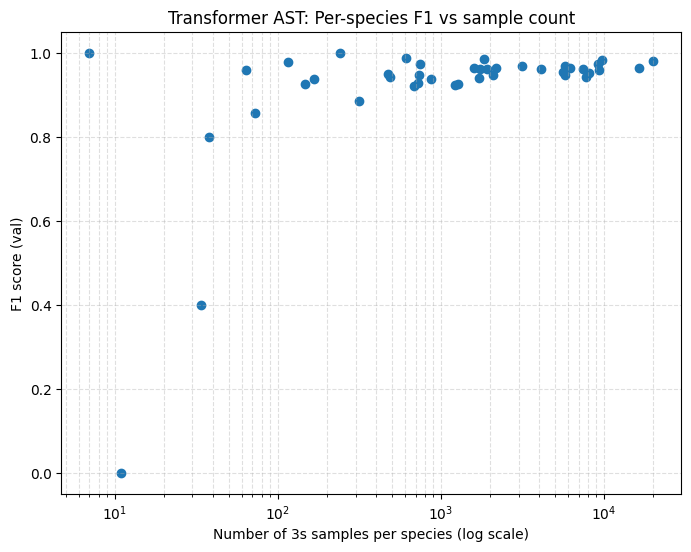

In [ ]:

# 18) Plot: F1 vs #samples (per class)

plt.figure(figsize=(8, 6))

plt.scatter(df_species_stats["n_samples"], df_species_stats["f1"])
plt.xscale("log")  # long-tailed, log scale helps
plt.xlabel("Number of 3s samples per species (log scale)")
plt.ylabel("F1 score (val)")
plt.title("Transformer AST: Per-species F1 vs sample count")

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.show()


In [ ]:

# 19) UMAP 2D projection of embeddings

!pip install umap-learn --quiet
# To keep things light, optionally subsample
MAX_POINTS = 5000
N = all_embs.shape[0]

if N > MAX_POINTS:
    idx = np.random.choice(N, size=MAX_POINTS, replace=False)
    emb_sample = all_embs[idx]
    label_sample = all_primary_species[idx]
else:
    emb_sample = all_embs
    label_sample = all_primary_species

print("Running UMAP on shape:", emb_sample.shape)

reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    metric="euclidean",
    random_state=SEED,
)
emb_2d = reducer.fit_transform(emb_sample.numpy())  # (M, 2)

emb_2d.shape


Running UMAP on shape: torch.Size([5000, 768])


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(5000, 2)

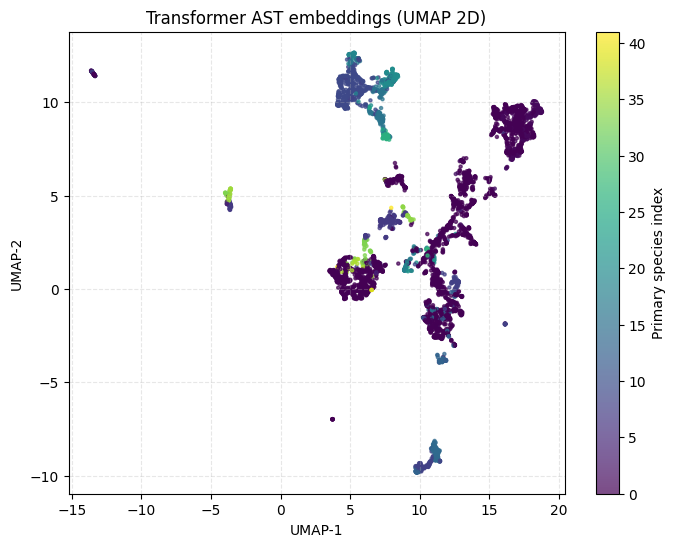

In [ ]:

# 20) Plot UMAP scatter, colored by "primary species"

plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    emb_2d[:, 0],
    emb_2d[:, 1],
    c=label_sample.numpy(),
    s=5,
    alpha=0.7,
)

plt.title("Transformer AST embeddings (UMAP 2D)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Primary species index")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


In [ ]:
# 21) Rarity buckets by quantiles of n_samples
q1 = df_species_stats["n_samples"].quantile(0.33)
q2 = df_species_stats["n_samples"].quantile(0.66)

def rarity_bucket(n):
    if n <= q1:
        return "rare"
    elif n <= q2:
        return "frequent"
    else:
        return "common"

df_species_stats["rarity"] = df_species_stats["n_samples"].apply(rarity_bucket)

df_species_stats.groupby("rarity")["f1"].mean()


,f1
rarity,
common,0.963496
frequent,0.949468
rare,0.830775


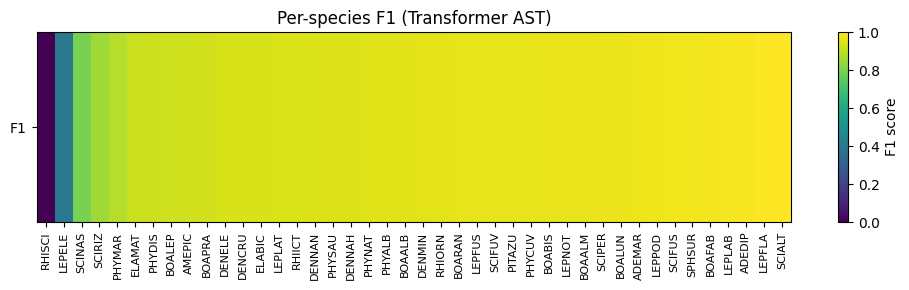

In [ ]:

# 22) Per-class F1 heatmap (species × F1)


# Making sure df_species_stats has columns: label_name, f1
# and that f1_c is aligned with label_cols
# (if not, re-run the earlier stats block)

# Sort by F1 or by class index as you prefer
df_heat = df_species_stats.sort_values("f1", ascending=True).reset_index(drop=True)

df_heat.to_csv("anuraset_f1_heatmap.csv", index=False)


f1_vals = df_heat["f1"].values  # shape (C,)
labels_sorted = df_heat["label_name"].tolist()

# Heatmap wants 2D -> make it (1, C)
heat_data = np.expand_dims(f1_vals, axis=0)

plt.figure(figsize=(10, 3))
im = plt.imshow(heat_data, aspect="auto")

plt.colorbar(im, label="F1 score")
plt.yticks([0], ["F1"])
plt.xticks(
    ticks=np.arange(len(labels_sorted)),
    labels=labels_sorted,
    rotation=90,
    fontsize=8
)

plt.title("Per-species F1 (Transformer AST)")
plt.tight_layout()
plt.show()


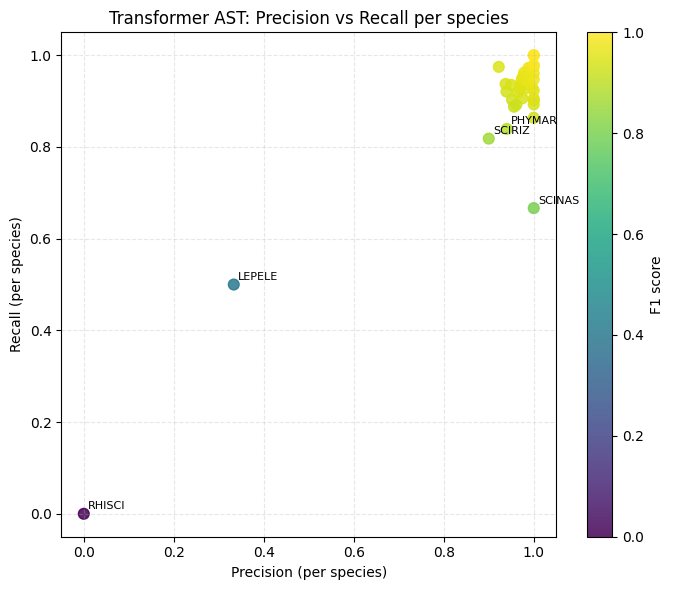

In [ ]:

# 23) Precision vs Recall scatter (per species, colored by F1)


# p_c, r_c, f1_c should be tensors of shape (C,)
precisions = p_c.numpy()
recalls    = r_c.numpy()
f1_values  = f1_c.numpy()

plt.figure(figsize=(7, 6))

sc = plt.scatter(
    precisions,
    recalls,
    c=f1_values,
    s=60,
    alpha=0.85
)

plt.xlabel("Precision (per species)")
plt.ylabel("Recall (per species)")
plt.title("Transformer AST: Precision vs Recall per species")
plt.grid(True, linestyle="--", alpha=0.3)
cbar = plt.colorbar(sc)
cbar.set_label("F1 score")

# Optionally annotate the worst few species
worst_idx = np.argsort(f1_values)[:5]
for idx in worst_idx:
    plt.text(
        precisions[idx] + 0.01,
        recalls[idx] + 0.01,
        df_species_stats.loc[df_species_stats["class_index"] == idx, "label_name"].values[0],
        fontsize=8
    )

plt.tight_layout()
plt.show()


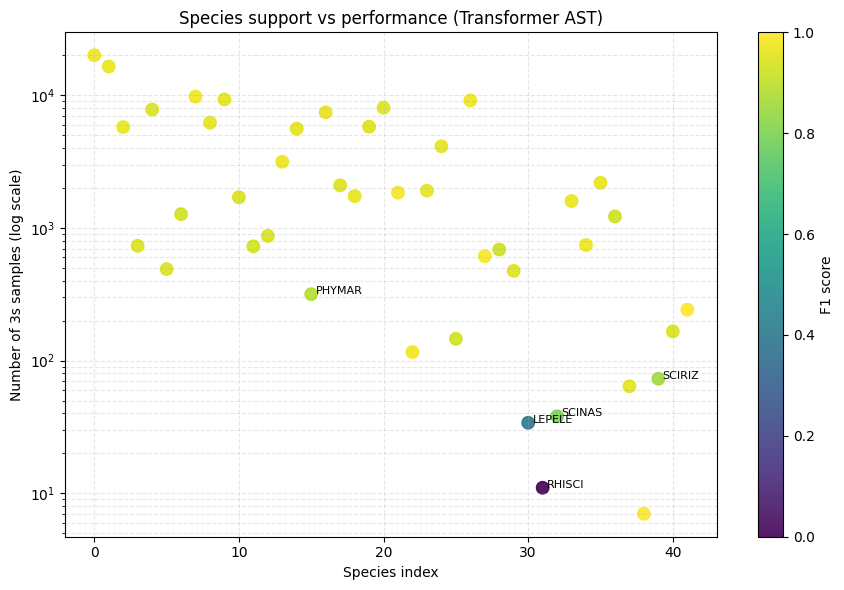

In [ ]:

# 24) Confusion-like plot: species dot colored by F1


# df_species_stats already has:
#   class_index, label_name, n_samples, f1

x = df_species_stats["class_index"].values
y = df_species_stats["n_samples"].values
c = df_species_stats["f1"].values

plt.figure(figsize=(9, 6))

sc = plt.scatter(
    x,
    y,
    c=c,
    s=80,
    alpha=0.9
)

plt.yscale("log")  # long-tailed distribution
plt.xlabel("Species index")
plt.ylabel("Number of 3s samples (log scale)")
plt.title("Species support vs performance (Transformer AST)")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
cbar = plt.colorbar(sc)
cbar.set_label("F1 score")

# show a few label names for very low F1
worst_idx = np.argsort(c)[:5]
for idx in worst_idx:
    row = df_species_stats.iloc[idx]
    plt.text(
        row["class_index"] + 0.3,
        row["n_samples"],
        row["label_name"],
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [ ]:

# 25) Soft confusion matrix: P(predicted j | true i present)


C = all_labels.shape[1]

# Binarize predictions
probs = torch.sigmoid(all_logits)
preds = (probs >= THRESHOLD).float()

labels_np = all_labels.numpy().astype(np.float32)   # (N, C)
preds_np  = preds.numpy().astype(np.float32)        # (N, C)

# raw_conf[i, j] = number of clips where species i is present
#                  AND species j is predicted
raw_conf = labels_np.T @ preds_np                   # (C, C)

# normalize by row -> P(pred j | true i)
row_sums = raw_conf.sum(axis=1, keepdims=True) + 1e-8
conf_norm = raw_conf / row_sums                     # (C, C)

conf_norm.shape



(42, 42)

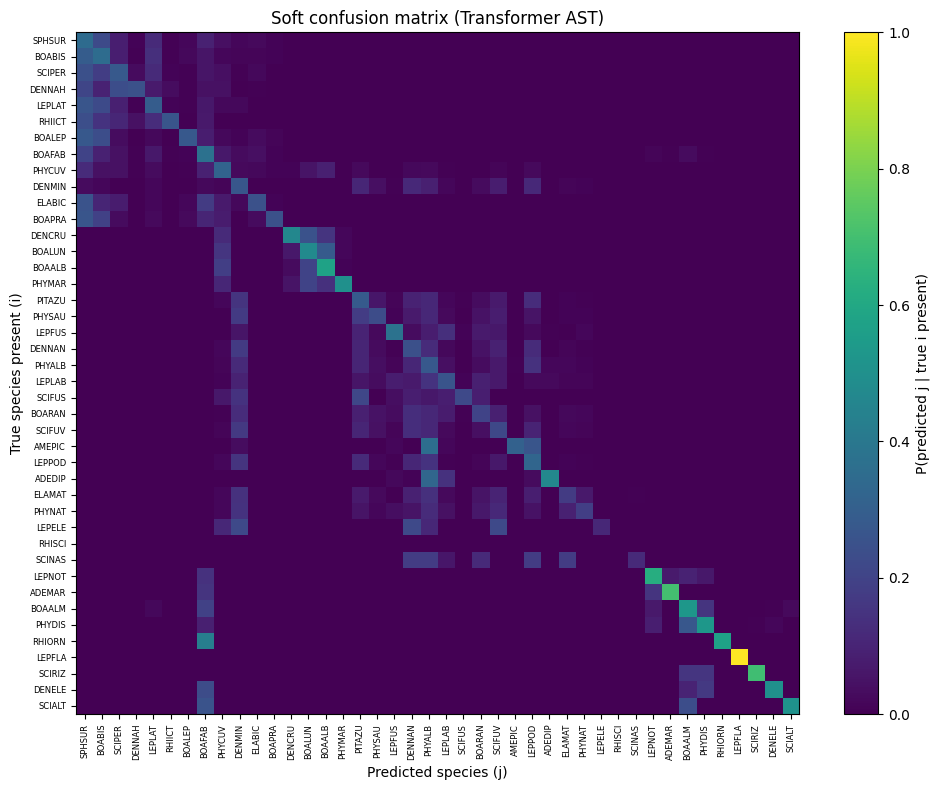

In [ ]:
plt.figure(figsize=(10, 8))

im = plt.imshow(conf_norm, aspect="auto", interpolation="nearest")
plt.colorbar(im, label="P(predicted j | true i present)")

plt.xticks(range(C), label_cols, rotation=90, fontsize=6)
plt.yticks(range(C), label_cols, fontsize=6)

plt.xlabel("Predicted species (j)")
plt.ylabel("True species present (i)")
plt.title("Soft confusion matrix (Transformer AST)")

plt.tight_layout()
plt.show()


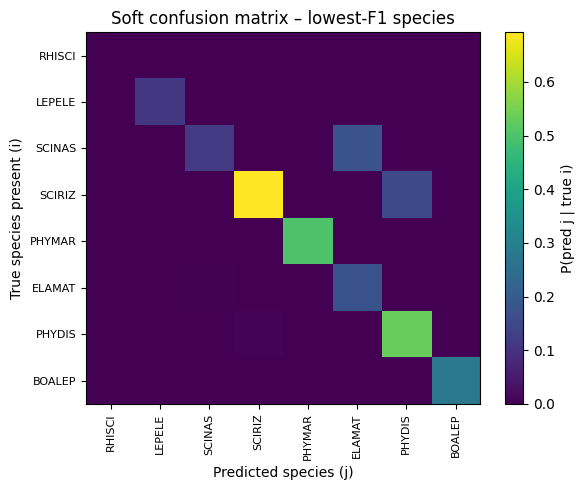

In [ ]:

# 26) Zoomed confusion for K lowest-F1 species

K = 8  # number of species to focus on

# Take indices of lowest-F1 species
worst_idx = (
    df_species_stats
    .sort_values("f1", ascending=True)
    .head(K)["class_index"]
    .tolist()
)

# Sub-matrix
conf_sub = conf_norm[np.ix_(worst_idx, worst_idx)]
labels_sub = [label_cols[i] for i in worst_idx]

plt.figure(figsize=(6, 5))
im = plt.imshow(conf_sub, aspect="auto", interpolation="nearest")
plt.colorbar(im, label="P(pred j | true i)")

plt.xticks(range(K), labels_sub, rotation=90, fontsize=8)
plt.yticks(range(K), labels_sub, fontsize=8)

plt.xlabel("Predicted species (j)")
plt.ylabel("True species present (i)")
plt.title("Soft confusion matrix – lowest-F1 species")

plt.tight_layout()
plt.show()


In [ ]:

# 27) Species Activity Across Biomes
# Convert multi-label matrix to long format
rows = []

for _, row in META.iterrows():
    site = row["site"]
    for sp in label_cols:
        rows.append({
            "site": site,
            "species": sp,
            "active": row[sp]
        })

df_activity = pd.DataFrame(rows)

# Compute activity rate per (species, site)
df_activity_rate = (
    df_activity
    .groupby(["species", "site"])["active"]
    .mean()
    .reset_index(name="activity_rate")
)

# Pivot to heatmap format
activity_pivot = df_activity_rate.pivot(
    index="species",
    columns="site",
    values="activity_rate"
).fillna(0)

print(activity_pivot.shape)
activity_pivot.head()



(42, 4)


site,INCT17,INCT20955,INCT4,INCT41
species,,,,
ADEDIP,0.029856,0.0,0.000000,0.000000
ADEMAR,0.000000,0.0,0.030542,0.000000
AMEPIC,0.007111,0.0,0.000000,0.000000
BOAALB,0.000000,0.0,0.000000,0.264179
BOAALM,0.000000,0.0,0.090066,0.000000


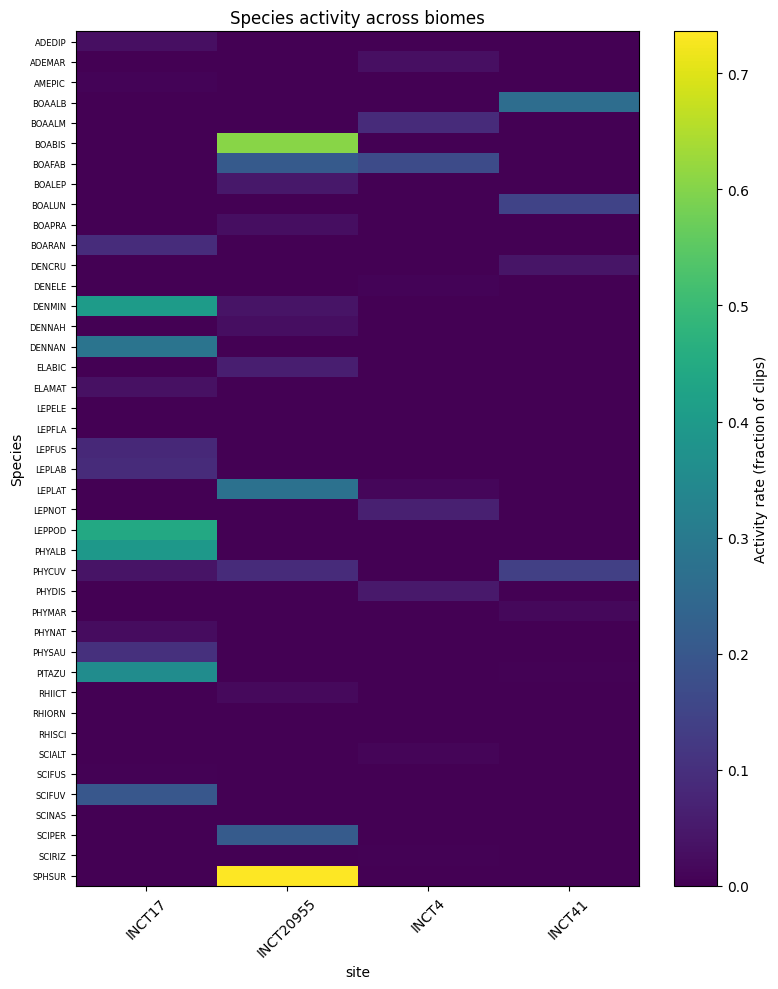

In [ ]:

plt.figure(figsize=(8, 10))

im = plt.imshow(activity_pivot.values, aspect="auto")

plt.colorbar(im, label="Activity rate (fraction of clips)")

plt.yticks(
    range(len(activity_pivot.index)),
    activity_pivot.index,
    fontsize=6
)

plt.xticks(
    range(len(activity_pivot.columns)),
    activity_pivot.columns,
    rotation=45
)

plt.title("Species activity across biomes")
plt.xlabel("site")
plt.ylabel("Species")

plt.tight_layout()
plt.show()


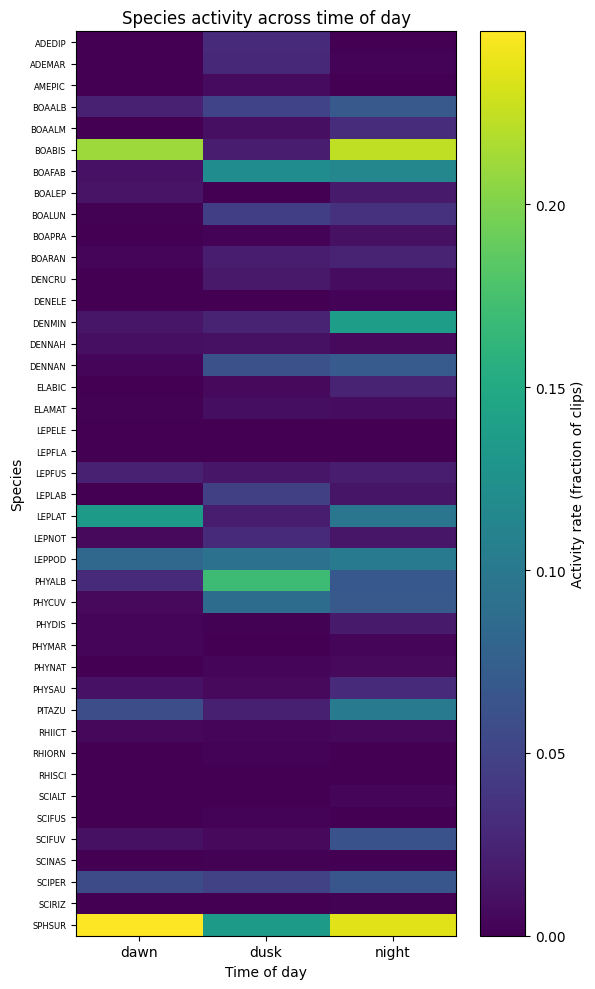

In [ ]:

# 28) Species Activity vs Time of day


# 1) Ensure time_of_day exists
META["date"] = pd.to_datetime(META["date"], errors="coerce")
META["hour"] = META["date"].dt.hour

def assign_time_of_day(h):
    if pd.isna(h):
        return "unknown"
    h = int(h)
    if 4 <= h < 7:
        return "dawn"
    elif 7 <= h < 17:
        return "day"
    elif 17 <= h < 20:
        return "dusk"
    else:
        return "night"

META["time_of_day"] = META["hour"].apply(assign_time_of_day)

# 2) Build df_activity_tod
records = []

for tod, df_t in META.groupby("time_of_day"):
    num_clips = len(df_t)
    active_counts = df_t[label_cols].sum(axis=0)
    activity_rate = active_counts / max(num_clips, 1)

    for sp, rate in activity_rate.items():
        records.append({
            "time_of_day": tod,
            "species": sp,
            "activity_rate": rate
        })

df_activity_tod = pd.DataFrame(records)

# 3) Enforce ordering
tod_order = ["dawn", "day", "dusk", "night"]

df_activity_tod["time_of_day"] = pd.Categorical(
    df_activity_tod["time_of_day"],
    categories=tod_order,
    ordered=True
)
df_activity_tod.to_csv("species_activity_time_of_day_long.csv", index=False)


# 4) Pivot
activity_tod_pivot = df_activity_tod.pivot(
    index="species",
    columns="time_of_day",
    values="activity_rate"
).fillna(0)

# 5) Plot
plt.figure(figsize=(6, 10))

im = plt.imshow(activity_tod_pivot.values, aspect="auto")

plt.colorbar(im, label="Activity rate (fraction of clips)")

plt.yticks(
    range(len(activity_tod_pivot.index)),
    activity_tod_pivot.index,
    fontsize=6
)

plt.xticks(
    range(len(activity_tod_pivot.columns)),
    activity_tod_pivot.columns
)

plt.title("Species activity across time of day")
plt.xlabel("Time of day")
plt.ylabel("Species")

plt.tight_layout()
plt.show()




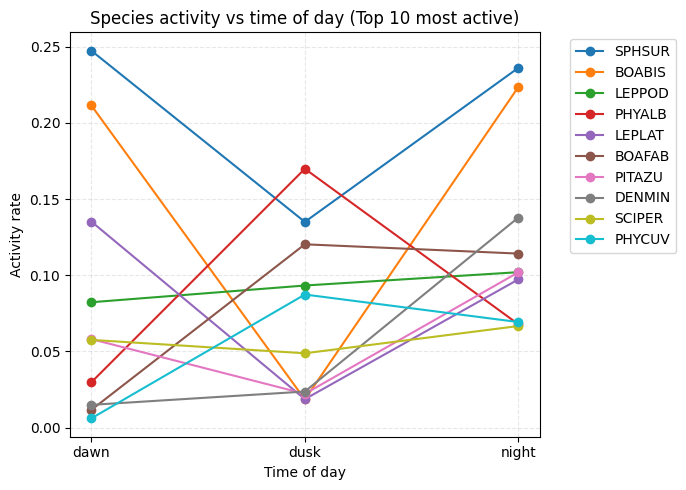

In [ ]:

# 29) Top Species activity - Time of day
# Select species with highest average activity
avg_activity = df_activity_tod.groupby("species")["activity_rate"].mean().sort_values(ascending=False)
top_species = avg_activity.head(10).index.tolist()


# Plot
existing_bins = ["dawn", "dusk", "night"]
plt.figure(figsize=(7, 5))
for sp in top_species:
    tmp = df_activity_tod[df_activity_tod["species"] == sp]
    tmp = tmp.set_index("time_of_day").reindex(existing_bins)
    plt.plot(existing_bins, tmp["activity_rate"], marker="o", label=sp)
plt.xlabel("Time of day")
plt.ylabel("Activity rate")
plt.title("Species activity vs time of day (Top 10 most active)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# PART 2: Classification and Segmentation
# 30) Gradio Set up

!pip install gradio -q
import gradio as gr

# a) Audio loader

def load_any_audio(path, target_sr=16000):
    """
    Load audio from WAV/MP3/etc -> mono float32 tensor at target_sr.
    Uses soundfile for decoding and torchaudio for resampling.
    """
    wav, sr = sf.read(path)          # (T,) or (T, C)

    # to mono
    if wav.ndim == 2:
        wav = wav.mean(axis=1)

    wav = torch.tensor(wav, dtype=torch.float32)

    # resample if needed
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav.unsqueeze(0), sr, target_sr).squeeze(0)

    return wav


# b) Sliding-window classification

def classify_audio_sliding(
    audio_path,
    window_sec=3.0,
    hop_sec=0.5,
    threshold=0.3,
    batch_size=32,
    device=device,
):
    """
    Run AST classifier on sliding windows.
    Returns:
      df_clip   : per-species clip-level scores
      df_windows: per-window probabilities (for segmentation, curves)
      duration  : audio length (seconds)
    """
    wav = load_any_audio(audio_path, TARGET_SR).float()
    num_samples = len(wav)
    duration = num_samples / TARGET_SR

    win_samples = int(window_sec * TARGET_SR)
    hop_samples = int(hop_sec * TARGET_SR)

    # pad if shorter than one window
    if num_samples < win_samples:
        wav = torch.nn.functional.pad(wav, (0, win_samples - num_samples))
        num_samples = len(wav)

    # build windows
    starts = list(range(0, num_samples - win_samples + 1, hop_samples))
    windows = []
    time_spans = []

    for s in starts:
        e = s + win_samples
        windows.append(wav[s:e])
        time_spans.append((s / TARGET_SR, e / TARGET_SR))

    windows = torch.stack(windows, dim=0)  # (Nw, T)

    # inference
    model.eval()
    all_probs = []

    with torch.no_grad():
        for i in range(0, len(windows), batch_size):
            batch = windows[i:i + batch_size]

            inputs = feature_extractor(
                batch.numpy(),
                sampling_rate=TARGET_SR,
                return_tensors="pt",
                padding=True,
            )
            inputs = {k: v.to(device) for k, v in inputs.items()}
            logits = model(**inputs).logits
            probs = torch.sigmoid(logits).cpu().numpy()  # (B, C)
            all_probs.append(probs)

    all_probs = np.concatenate(all_probs, axis=0)  # (Nw, C)

    # clip-level stats
    prob_max = all_probs.max(axis=0)
    prob_mean = all_probs.mean(axis=0)
    flags = (prob_max >= threshold).astype(int)

    df_clip = pd.DataFrame({
        "species": label_cols,
        "prob_max": prob_max,
        "prob_mean": prob_mean,
        "flag": flags,
    }).sort_values("prob_max", ascending=False)

    # per-window probabilities (long format)
    rows = []
    for w_idx, (t0, t1) in enumerate(time_spans):
        for c_idx, sp in enumerate(label_cols):
            rows.append({
                "window": w_idx,
                "t_start": t0,
                "t_end": t1,
                "t_mid": 0.5 * (t0 + t1),
                "species": sp,
                "prob": float(all_probs[w_idx, c_idx]),
            })
    df_windows = pd.DataFrame(rows)

    return df_clip, df_windows, duration



# c) Window-level probs -> segments

def windows_to_segments(df_windows, threshold=0.3, min_duration=0.1):
    """
    Convert per-window probabilities into contiguous segments.
    Returns: DataFrame[species, start, end, duration, prob_mean, prob_max]
    """
    segments = []

    for sp, df_sp in df_windows.groupby("species"):
        df_sp = df_sp.sort_values("t_start")
        probs = df_sp["prob"].values
        t_starts = df_sp["t_start"].values
        t_ends = df_sp["t_end"].values

        active = probs >= threshold
        start_t = None
        cur_probs = []

        for i, on in enumerate(active):
            if on and start_t is None:
                start_t = t_starts[i]
                cur_probs = [probs[i]]
            elif on:
                cur_probs.append(probs[i])
            elif (not on) and start_t is not None:
                end_t = t_ends[i - 1]
                dur = end_t - start_t
                if dur >= min_duration:
                    segments.append({
                        "species": sp,
                        "start": float(start_t),
                        "end": float(end_t),
                        "duration": float(dur),
                        "prob_mean": float(np.mean(cur_probs)),
                        "prob_max": float(np.max(cur_probs)),
                    })
                start_t = None
                cur_probs = []

        if start_t is not None:
            end_t = t_ends[len(active) - 1]
            dur = end_t - start_t
            if dur >= min_duration:
                segments.append({
                    "species": sp,
                    "start": float(start_t),
                    "end": float(end_t),
                    "duration": float(dur),
                    "prob_mean": float(np.mean(cur_probs)),
                    "prob_max": float(np.max(cur_probs)),
                })

    return pd.DataFrame(segments)


# d) Log-mel spectrogram

def compute_log_mel_spectrogram(wav, sr, n_mels=128, n_fft=1024, hop_length=256):
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
    )
    with torch.no_grad():
        spec = mel(wav)
        spec = torch.log(spec + 1e-6)
    spec_np = spec.numpy()
    num_frames = spec_np.shape[1]
    frame_times = np.arange(num_frames) * (hop_length / sr)
    return spec_np, frame_times


# e) Build the matplotlib figure (waveform + spec + probs)

def make_demo_figure(
    audio_path,
    df_clip,
    df_windows,
    segments_df,
    top_k=3,
    sr=TARGET_SR,
):
    # load audio
    wav = load_any_audio(audio_path, sr).float()
    duration = len(wav) / sr
    t = np.linspace(0, duration, len(wav))

    # spectrogram
    spec_np, frame_times = compute_log_mel_spectrogram(wav, sr)

    # choose top_k species
    top_species = df_clip.head(top_k)["species"].tolist()

    # color map
    palette = ["tab:blue", "tab:orange", "tab:green", "tab:red",
               "tab:purple", "tab:brown", "tab:pink", "tab:gray"]
    sp_colors = {sp: palette[i % len(palette)] for i, sp in enumerate(top_species)}

    # window probs for curves
    df_top = df_windows[df_windows["species"].isin(top_species)]

    # figure layout
    fig, axes = plt.subplots(
        3, 1, figsize=(10, 7),
        sharex=True,
        gridspec_kw={"height_ratios": [1, 1.5, 1]}
    )
    ax_wave, ax_spec, ax_prob = axes

    # 1) Waveform + segments
    ax_wave.plot(t, wav.numpy(), linewidth=0.6, color="black")
    ax_wave.set_ylabel("Amplitude")
    ax_wave.set_title("Classification + Segmentation Demo")

    for _, seg in segments_df[segments_df["species"].isin(top_species)].iterrows():
        c = sp_colors.get(seg["species"], "tab:gray")
        ax_wave.axvspan(seg["start"], seg["end"], color=c, alpha=0.25)

    # 2) Spectrogram + segments
    im = ax_spec.imshow(
        spec_np,
        origin="lower",
        aspect="auto",
        extent=[frame_times[0], frame_times[-1], 0, spec_np.shape[0]],
    )
    ax_spec.set_ylabel("Mel bin")
    fig.colorbar(im, ax=ax_spec, label="Log-mel power")

    for _, seg in segments_df[segments_df["species"].isin(top_species)].iterrows():
        c = sp_colors.get(seg["species"], "tab:gray")
        ax_spec.axvspan(seg["start"], seg["end"], color=c, alpha=0.25)

    # 3) Probability curves
    for sp in top_species:
        d = df_top[df_top["species"] == sp].sort_values("t_mid")
        ax_prob.plot(
            d["t_mid"], d["prob"],
            marker="o", markersize=3, linewidth=1.0,
            label=sp, color=sp_colors[sp]
        )

    ax_prob.axhline(0.3, color="gray", linestyle="--", alpha=0.5, label="threshold")
    ax_prob.set_ylabel("Prob.")
    ax_prob.set_xlabel("Time (s)")
    ax_prob.set_ylim(0, 1.05)
    ax_prob.grid(alpha=0.3)
    ax_prob.legend(loc="upper right", fontsize=8)

    plt.tight_layout()
    return fig


# f) Gradio wrapper function

def gradio_infer(
    audio_file,
    window_sec=3.0,
    hop_sec=0.5,
    threshold=0.3,
    top_k=3,
):
    """
    audio_file: filepath from gr.Audio(type="filepath")
    Returns:
      - matplotlib figure
      - top-k predictions (DataFrame)
      - segments (DataFrame)
    """
    if audio_file is None:
        return None, pd.DataFrame(), pd.DataFrame()

    audio_path = audio_file  # it's already a path

    df_clip, df_windows, duration = classify_audio_sliding(
        audio_path,
        window_sec=window_sec,
        hop_sec=hop_sec,
        threshold=threshold,
    )

    segments_df = windows_to_segments(
        df_windows,
        threshold=threshold,
        min_duration=0.1,
    )

    fig = make_demo_figure(
        audio_path,
        df_clip,
        df_windows,
        segments_df,
        top_k=top_k,
    )

    df_topk = df_clip.head(top_k)[["species", "prob_max", "prob_mean", "flag"]]

    return fig, df_topk, segments_df



# g) Gradio UI

with gr.Blocks() as demo:
    gr.Markdown("## 🐸 AnuraSet – Transformer Classification & Segmentation Demo")

    with gr.Row():
        audio_in = gr.Audio(
            sources=["upload", "microphone"],
            type="filepath",
            label="Upload or record frog audio",
        )

        with gr.Column():
            window_sec = gr.Slider(1.0, 5.0, value=3.0, step=0.5, label="Window length (s)")
            hop_sec    = gr.Slider(0.1, 3.0, value=0.5, step=0.1, label="Hop size (s)")
            threshold  = gr.Slider(0.1, 0.9, value=0.3, step=0.05, label="Detection threshold")
            top_k      = gr.Slider(1, 6, value=3, step=1, label="Top-k species to show", interactive=True)
            submit_btn = gr.Button("Run classification + segmentation")

    fig_out = gr.Plot(label="Waveform + Spectrogram + Probability Curves")
    preds_out = gr.Dataframe(label="Top-k species predictions")
    segs_out = gr.Dataframe(label="Detected segments (all species)")

    submit_btn.click(
        fn=gradio_infer,
        inputs=[audio_in, window_sec, hop_sec, threshold, top_k],
        outputs=[fig_out, preds_out, segs_out],
    )

demo.launch()



It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://686b0ecb42ba2ec1da.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
